# 

# Utilizing data from OCG Federated ERDDAP

In this notebook we use data from one ERDDAP  to make subsequent queries to other ERDDAPs supplying data

In [12]:
import datetime
import pandas as pd
from erddapy import ERDDAP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def cartopy_map(lon, lat):
    central_lon = (lon.min() + lon.max())/2
    central_lat = (lat.min() + lat.max())/2
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(projection=ccrs.AzimuthalEquidistant(central_latitude=central_lat, central_longitude=central_lon))
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(color='k', alpha=0.2)
    #ax.set_extent([lon.min()-0.5, lon.max()+0.5, lat.min()-0.5, lat.max()+1.5], crs=ccrs.PlateCarree())
    return ax

### 1. Animal telemetry data - AniBOS 

We can use ERDDAP's built in search function to find datasets that match a keyword. Let's find some animal borne sensor data

In [13]:
e_osmc = ERDDAP(
    server="https://osmc.noaa.gov/erddap",
    protocol="tabledap"
)
url = e_osmc.get_search_url(search_for="animal", response="csv")

animals = pd.read_csv(url)
animals[["Dataset ID", "Title", "Summary"]]

,Dataset ID,Title,Summary
0,MEOP_profiles,"MEOP animal profiles, v2024","MEOP animal profiles, v2024\n\ncdm_data_type =..."
1,anibos_movement_data,AniBOS movement data,Animal Borne Ocean Sensor movement data\n\ncdm...


In [14]:
e_osmc.dataset_id = animals["Dataset ID"][0]

In [15]:
e_osmc.variables = ['species']
species = e_osmc.to_pandas()

In [16]:
species

,species
0,Australian sea lion
1,Bearded seal
2,Blueback hooded
3,Bluebacks
4,California sea lion
5,Crabeater seal
6,Flatback turtle
7,Fur seal
8,Green turtle
9,Grey


In [17]:
e_osmc.constraints = {'species=': 'Southern ellie', #'Southern ellie', 'Crabeater seal'
                 'longitude>=': 70,
                 'longitude<=': 90,
                 'latitude<=': -60,
                 'PRES<=': 5,
                 'time>=':"2015-01-01T00:00:00Z"
}
e_osmc.variables = ['latitude', 'longitude', 'time', 'species']
df = e_osmc.to_pandas()
df

,latitude (degrees_north),longitude (degrees_east),time (UTC),species
0,-60.0301,83.9079,2015-02-19T20:50:00Z,Southern ellie
1,-60.3674,84.3458,2015-02-20T13:00:00Z,Southern ellie
2,-60.7454,85.2354,2015-02-21T07:10:00Z,Southern ellie
3,-60.8555,85.0326,2015-02-21T16:20:00Z,Southern ellie
4,-60.7534,85.0542,2015-02-22T02:50:00Z,Southern ellie
...,...,...,...,...
809,-64.2471,71.9606,2016-04-28T09:20:00Z,Southern ellie
810,-64.1494,71.5299,2016-04-28T17:10:00Z,Southern ellie
811,-64.0413,71.3315,2016-04-28T21:20:00Z,Southern ellie
812,-64.0005,70.7443,2016-04-29T03:00:00Z,Southern ellie


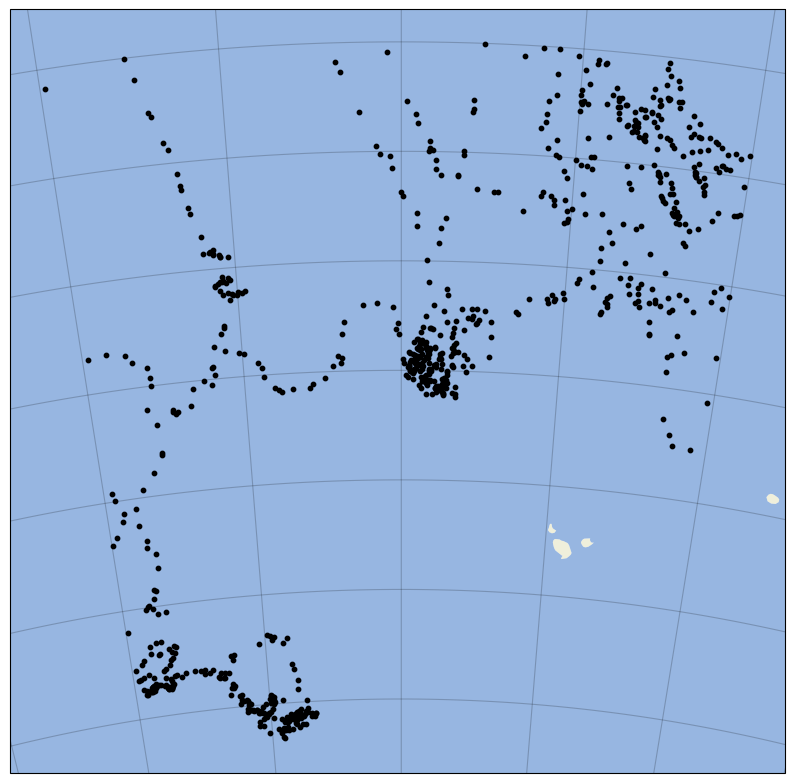

In [18]:
ax = cartopy_map(df['longitude (degrees_east)'], df['latitude (degrees_north)'])
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=10)


### 2. Add GO-SHIP bottle data

We use a bounding box from the lon, lat and time of the seal data to look for co-located bottle data

In [19]:
e_bottle = ERDDAP(
    server="https://osmc.noaa.gov/erddap",
    protocol="tabledap"
)
url = e_bottle.get_search_url(search_for="bottle", response="csv")

ship = pd.read_csv(url)
ship[["Dataset ID", "Title", "Summary"]]


,Dataset ID,Title,Summary
0,cchdo_bottle,CCHDO GO SHIP bottle data,CCHDO GO SHIP bottle data from netcdf\n\ncdm_d...
1,cchdo_ctd,CCHDO GO SHIP ctd data,CCHDO GO SHIP ctd data from netcdf files\n\ncd...


In [20]:
e_bottle.dataset_id = "cchdo_bottle"
e_bottle.constraints = {'time>=': df["time (UTC)"].min(),
 'time<=': df["time (UTC)"].max(),
 'latitude>=':  df['latitude (degrees_north)'].min(),
 'latitude<=':  df['latitude (degrees_north)'].max(),
 'longitude>=': df['longitude (degrees_east)'].min(),
 'longitude<=': df['longitude (degrees_east)'].max(),}


In [21]:
df_cchdo = e_bottle.to_pandas()
df_cchdo

,profile_id,expocode,section_id,line_id,station,cast,sample,bottle_number,bottle_number_qc,time (UTC),...,xenon,xenon_qc,xenon_error,xenon_l,xenon_l_qc,xenon_l_error,profile_type,geometry_container,N_PROF,N_LEVELS
0,33RR20160208_1_1,33RR20160208,I08S,NaN,1,1,20,20,2,2016-02-19T05:57:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,0,0
1,33RR20160208_1_1,33RR20160208,I08S,NaN,1,1,19,19,2,2016-02-19T05:57:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,0,1
2,33RR20160208_1_1,33RR20160208,I08S,NaN,1,1,18,18,2,2016-02-19T05:57:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,0,2
3,33RR20160208_1_1,33RR20160208,I08S,NaN,1,1,17,17,2,2016-02-19T05:57:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,0,3
4,33RR20160208_1_1,33RR20160208,I08S,NaN,1,1,16,16,2,2016-02-19T05:57:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,33RR20160208_17_1,33RR20160208,I08S,NaN,17,1,5,5,2,2016-02-23T06:11:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,16,22
524,33RR20160208_17_1,33RR20160208,I08S,NaN,17,1,4,4,2,2016-02-23T06:11:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,16,23
525,33RR20160208_17_1,33RR20160208,I08S,NaN,17,1,3,3,2,2016-02-23T06:11:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,16,24
526,33RR20160208_17_1,33RR20160208,I08S,NaN,17,1,2,2,2,2016-02-23T06:11:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,16,25


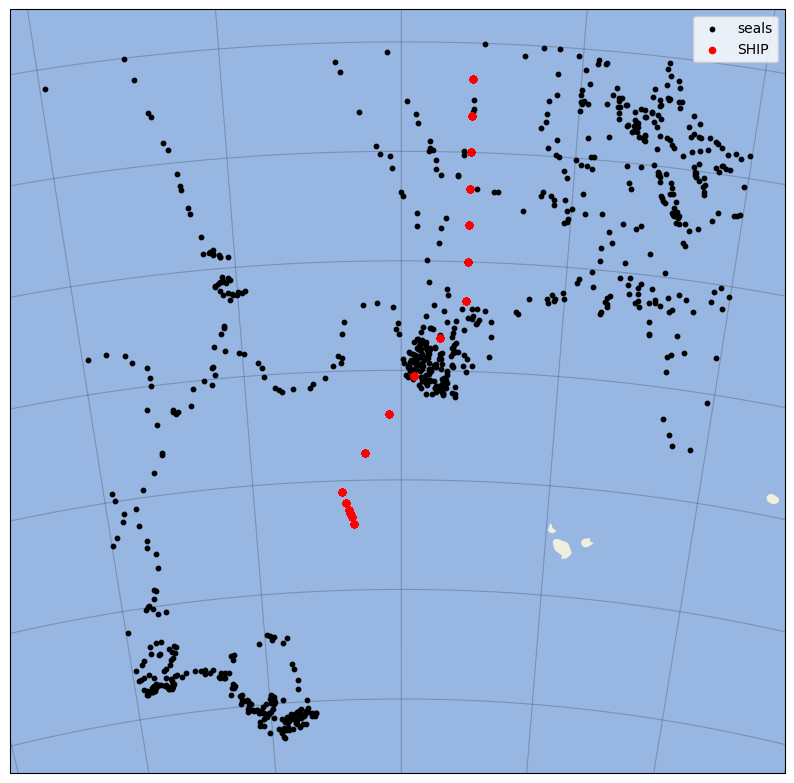

In [22]:
ax = cartopy_map(df['longitude (degrees_east)'], df['latitude (degrees_north)'])
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=10, label="seals")
ax.scatter(df_cchdo['longitude (degrees_east)'], df_cchdo['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color="r", s=20, label="SHIP")
ax.legend()